<a href="https://colab.research.google.com/github/JuniorHZ19/ML/blob/main/ResNet2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
#@markdown # *0) ** Instalando libreria(OBLIGATORIO)

!pip install torch torchvision torchaudio

In [111]:
#@markdown # *1) ** Usar el dataset CIFAR 10


import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Definir transformaciones para normalizar las imágenes
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((100,100)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Descargar el conjunto de datos CIFAR-10

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear cargadores de datos para facilitar el acceso a lotes de datos

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=200, shuffle=False)




100%|██████████| 170498071/170498071 [00:03<00:00, 52456254.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [113]:
import torch.nn as nn
import torch.nn.functional as F



class BloqueResidual(nn.Module):
   def __init__(self,out_channels,conv1x1=False,strides=1):
    super(BloqueResidual,self).__init__()

    self.conv1=nn.LazyConv2d(out_channels,kernel_size=3,padding=1,stride=strides)
    self.bn1=nn.BatchNorm2d(out_channels)
    self.conv2=nn.LazyConv2d(out_channels,kernel_size=3,padding=1)
    self.bn2=nn.BatchNorm2d(out_channels)

    if(conv1x1==True):
     self.conv1x1=nn.LazyConv2d(out_channels,kernel_size=1,stride=strides)
     print("se aplicao conv1x1")
    else:
     self.conv1x1=None

   def forward(self,x):

     fx=self.conv1(x)
     fx=self.bn1(fx)
     fx=F.relu(fx)

     fx=self.conv2(fx)
     fx=self.bn2(fx)
     if(self.conv1x1):
      x=self.conv1x1(x)

     Y=x+fx

     return F.relu(Y)


In [114]:
import torch


blk=BloqueResidual(3,True,2)
x=torch.randn(4,3,16,16)
print(blk)

se aplicao conv1x1
BloqueResidual(
  (conv1): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1x1): LazyConv2d(0, 3, kernel_size=(1, 1), stride=(2, 2))
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [115]:
import torch.nn as nn
import torch.nn.functional as F



class ResModulo(nn.Module):
   def __init__(self,out_channels,num_block,FirstModule=False):
    super(ResModulo,self).__init__()
    print(num_block)
    blk=[]
    for i in range(num_block):

      if (i==0 and FirstModule!=True):
         blk.append(BloqueResidual(out_channels,conv1x1=True,strides=2))
      else:
         blk.append(BloqueResidual(out_channels))

    self.net=nn.Sequential(*blk)



   def forward(self,x):
     out=self.net(x)
     return out

In [116]:
resmodulo=ResModulo(3,5)
print (resmodulo)

5
se aplicao conv1x1
ResModulo(
  (net): Sequential(
    (0): BloqueResidual(
      (conv1): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1x1): LazyConv2d(0, 3, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): BloqueResidual(
      (conv1): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BloqueResidual(
      (conv1): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b

In [120]:
import torch.nn as nn
import torch.nn.functional as F



class ResNet(nn.Module):
   def __init__(self,arch,num_clases):
    super(ResNet,self).__init__()

    self.base=nn.Sequential(nn.LazyConv2d(64,kernel_size=7,stride=2),
                            nn.MaxPool2d(kernel_size=2))

    body_net=[]
    for i,trupla in enumerate(arch):
     num_bloques,channels=trupla
     if(i==0):
      body_net.append(ResModulo(channels,num_bloques,FirstModule=True))
     else:
      body_net.append(ResModulo(channels,num_bloques))

    self.net=nn.Sequential(self.base,
                           *body_net)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.flaten=nn.Flatten();
    self.lineal=nn.LazyLinear(num_clases);

   def forward(self,x):
     x=self.net(x)
     x=self.avgpool(x)
     x=self.flaten(x)
     out=self.lineal(x)
     return out

In [122]:
resnet18=ResNet([(2,64),(2,128),(2,256),(2,512)],10)
print(resnet18)

2
2
se aplicao conv1x1
2
se aplicao conv1x1
2
se aplicao conv1x1
ResNet(
  (base): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ResModulo(
      (net): Sequential(
        (0): BloqueResidual(
          (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BloqueResidual(
          (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:


import torch
import torch.optim as optim

if torch.cuda.is_available():
    print("CUDA está disponible.")
    device = torch.device("cuda")
else:
    print("CUDA no está disponible. Se utilizará la CPU.")
    device = torch.device("cpu")


#funcion clasificador:
def clasificador(y_pred_test):
 max_values_tensor=torch.empty((0,),dtype=torch.float32,device="cuda")

 for tensor in y_pred_test:

   max_values,max_indices=torch.max(tensor,dim=0)
   max_values_tensor=torch.cat((max_values_tensor,max_indices.unsqueeze(0)))

 return max_values_tensor

#funcion acutity:
def accurity(y_test,y_real):
   correctos=0
   for predicho, real in zip(y_test, y_real):
    if predicho==real:
     correctos+=1
   return correctos/len(y_test)


def ResNet18Train(modelo,optimisador,epocas,criterio,data_loader_train,data_loader_test):

 for epoch in  range(epocas):
  total_train_loss = 0.0
  num_train_batches = len(data_loader_train)
  modelo.train()

  for x,y in (data_loader_train):
   x,y=x.to(device),y.to(device)

   y_predict=modelo(x)

   loss=criterio(y_predict,y)

   optimisador.zero_grad()

   loss.backward()

   optimisador.step()

   optimisador.zero_grad()

   total_train_loss+=loss.item()

  modelo.eval()

  with torch.no_grad():
   total_test_accuracy = 0.0
   num_test_batches = len(data_loader_test)

   for x_test,y_test in (data_loader_test):
     x_test,y_test=x_test.to(device),y_test.to(device)
     y_predict_test=modelo(x_test)
     y_predic_test_clasificado=clasificador(y_predict_test)
     Precision=accurity(y_test,y_predic_test_clasificado)
     total_test_accuracy += Precision

  avg_test_accuracy = total_test_accuracy / num_test_batches
  avg_train_loss=total_train_loss/num_train_batches
  print(f'Epoca[{epoch+1}], Perdida: {avg_train_loss:.4f},Accuryty:{avg_test_accuracy:.4f}')


#------------------------------------------------------------------------------------------


resnet18=ResNet([(2,64),(2,128),(2,256),(2,512)],10)

print(resnet18)
# Cargar los pesos previamente guardados

#AlexnetRed.load_state_dict(torch.load('/content/alexnet.pt')) #solo para reentrenar

Resnet18=resnet18.to(device)

criterio=nn.CrossEntropyLoss()

optimizer=optim.Adam(resnet18.parameters(),lr=0.01)

epochs=20


ResNet18Train(Resnet18,optimizer,epochs,criterio,train_loader,test_loader)

CUDA está disponible.
2
2
se aplicao conv1x1
2
se aplicao conv1x1
2
se aplicao conv1x1
ResNet(
  (base): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ResModulo(
      (net): Sequential(
        (0): BloqueResidual(
          (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BloqueResidual(
          (conv1): LazyConv2d(0, 64, kernel_size=(3,

In [ ]:
torch.save(VGGRED.state_dict(), 'vgg16.pt')

CUDA está disponible.
AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (salida): Linear(in_features=4096, out_features=10, bias=True)
)
torch.Size([3, 227, 227])


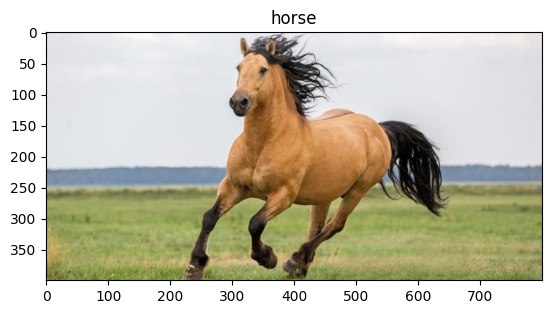

torch.Size([3, 227, 227])


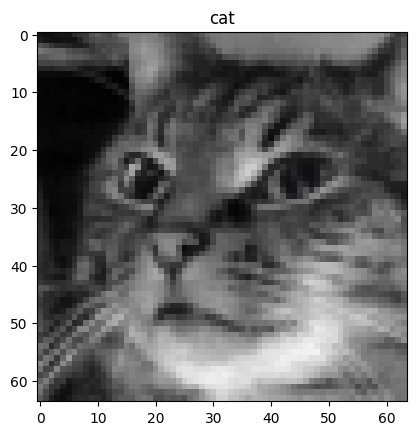

torch.Size([3, 227, 227])


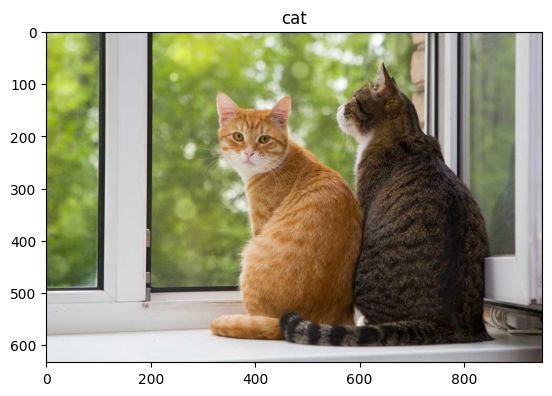

torch.Size([3, 227, 227])


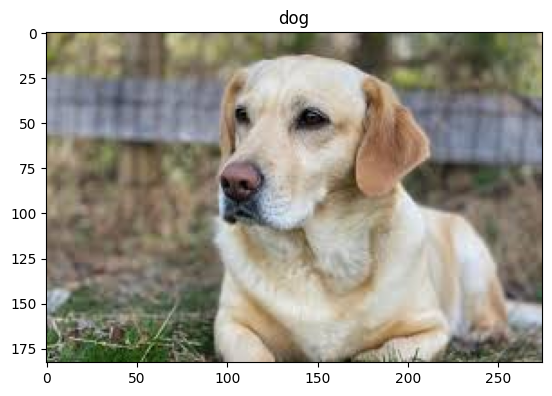

La imagen prr.jpg no es un archivo .jpg o .png y será ignorada.


In [ ]:

import torch

from torchvision import  transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
if torch.cuda.is_available():
    print("CUDA está disponible.")
    device = torch.device("cuda")
else:
    print("CUDA no está disponible. Se utilizará la CPU.")
    device = torch.device("cpu")

def clasificador(y_pred_test):
 max_values_tensor=torch.empty((0,),dtype=torch.float32,device="cuda")

 for tensor in y_pred_test:

   max_values,max_indices=torch.max(tensor,dim=0)
   max_values_tensor=torch.cat((max_values_tensor,max_indices.unsqueeze(0)))

 return max_values_tensor

# Definir transformaciones para normalizar las imágenes
transformaciones = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((227,227)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


AlexnetRed=AlexNet()
print(AlexnetRed)
AlexnetRed.load_state_dict(torch.load('/content/alexnet.pt'))
AlexnetRed=AlexnetRed.to(device)


carpeta="/content/samples/"

lista_imagenes=os.listdir(carpeta)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for imagen_ruta  in (lista_imagenes):
  if imagen_ruta.lower().endswith(('.jpg', '.png','.jpeg')):
   imagen = Image.open(carpeta+imagen_ruta)
   plt.imshow(imagen)
   imagen_tansformada= transformaciones(imagen)
   imagen_tansformada=imagen_tansformada.to(device)
   AlexnetRed.eval()
   with torch.no_grad():
    print(imagen_tansformada.shape)
    y_predi=AlexnetRed(imagen_tansformada.unsqueeze(0))
    clase=clasificador(y_predi)

    etiqueta=classes[int(clase.item())]
    plt.title(etiqueta)
    plt.show()
else:
        print(f"La imagen {imagen_ruta} no es un archivo .jpg o .png y será ignorada.")